**Research**

•Как сезонность влияет на продажи

•Как признаки влияют на продажи. Можно ли с помощью признаков и сезонности предсказать продажи на неделю?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter 
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = r'sales_and_features.csv'
df = pd.read_csv(path, engine= 'python')
features_initial = list(df.drop(['Date', 'Sales_size'], axis = 1).columns)

In [3]:
df.head()

,Date,Sales_size,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,2015-01-01,4.013723,151976,136,0,0,15663,0,0,0,661,0
1,2015-01-02,7.220396,204223,185,0,0,20075,0,0,0,5404,0
2,2015-01-03,8.195494,158073,146,0,0,11251,0,0,0,1103,0
3,2015-01-04,7.637879,161828,146,0,0,14118,0,0,0,1213,0
4,2015-01-05,5.982856,241127,209,0,0,644286,0,0,676,78757,0


## Как сезонность влияет на продажи?

Перед нами продажи за 3 года (допустим магазина). Посмотрим на общий график объема продаж.
Что мы видим из графика:
 - В первой половине 2015 года были низкие продажи (возможно магазин недавно открылся, по другому велась статистика, кризис, итд)
 - В марте, начале апреля 2016 года есть несколько дней со значительным падением продаж (возможно магазин был "на ремонте")
 - В конце каждого года наблюдается снижение продаж


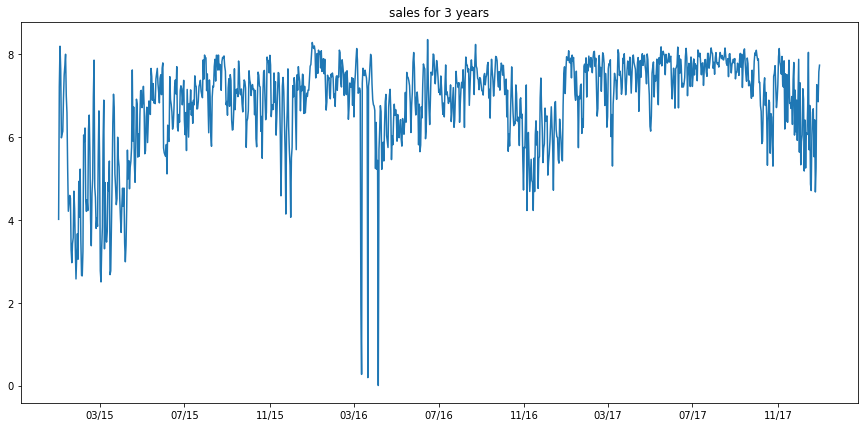

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

#ploting the graph
myFmt = DateFormatter("%m/%y")

fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('sales for 3 years')

ax.xaxis.set_major_formatter(myFmt)
ax.plot(df['Date'], df['Sales_size'])


Для дальнейшего анализа рассмотрим средние продажи магазина в следующих разрезах:
 - Год
 - Время года (зима, осень, ..)
 - Месяц
 - Номер недели
 - День недели
 
Для этого создадим новые признаки:


In [5]:
new_date_features = ['year', 'month', 'month_name', 'week_num', 'week_day', 'season']

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['month_name'] = df['Date'].dt.strftime('%b')
df['week_num'] = df['Date'].dt.week
df['week_day'] = df['Date'].dt.strftime('%w').astype('int')

"""
1: winter
2: spring
3: summer
4: autumn
"""
seasons = {1: [1, 2, 12],
           2: [3, 4, 5],
           3: [6, 7, 8],
           4: [9, 10, 11]}

df['season'] = df['month'].apply(lambda x: [season for season, months in seasons.items() if x in months][0]  )

df = df[['Sales_size', 'Date'] + new_date_features + features_initial]

Обратим внимание, что средние годовые продажи магазина растут в течение 3 лет

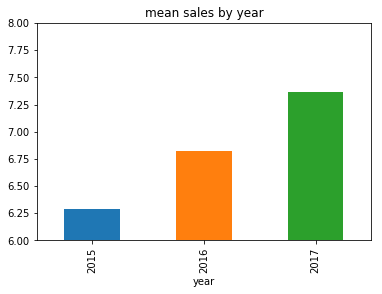

In [6]:
df.groupby('year')['Sales_size'].mean().plot(kind = 'bar', ylim = (6,8), title = 'mean sales by year')

Время года оказывает влияние на средние продажи магазина:
 - Высокие продажи летом (3)
 - Продажи осенью (4) превышают продажи зимой (1) и весной (2)

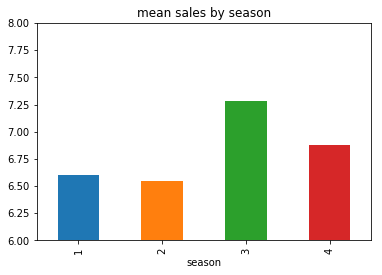

In [7]:
df.groupby(['season'])['Sales_size'].mean().plot(kind = 'bar', ylim = (6,8), title = 'mean sales by season')

Номер месяца также оказывает значительное влияние на средние продажи магазина:
 - Высокие продажи с мая по сентябрь-октябрь

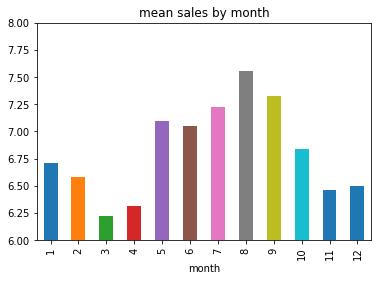

In [8]:
df.groupby('month')['Sales_size'].mean().plot(kind = 'bar', ylim = (6,8), title = 'mean sales by month')

Если посмотреть на продажи в разрезе номера недели, то можно заметить следующее:
 - Высокие продажи приходятся на предпраздничные периоды (например, период до новогодних праздников, неделя перед 8 марта)
 - Высокие продажи приходятся на значительное количество недель с мая по сентябрь - октябрь

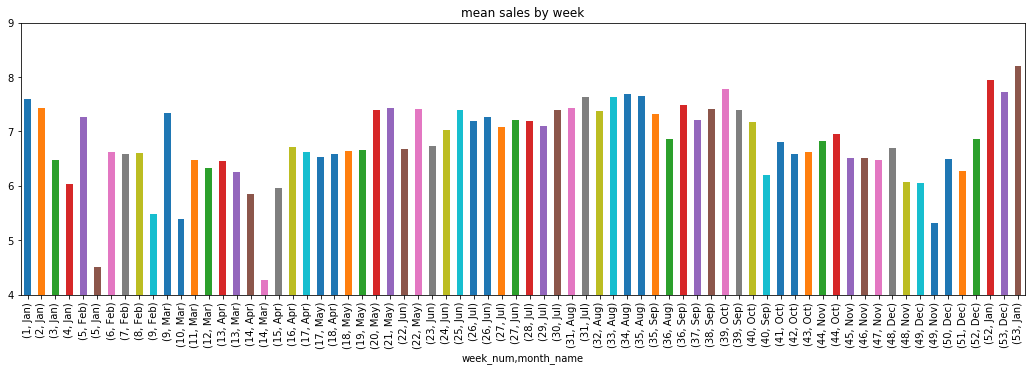

In [9]:
df.groupby(['week_num', 'month_name'])['Sales_size'].mean().plot(kind = 'bar', figsize =(18,5), ylim = (4,9), \
                                                                 title = 'mean sales by week')

В пределах недели высокие продажи ожидаемо приходятся на четверг (4) - воскресенье (0)

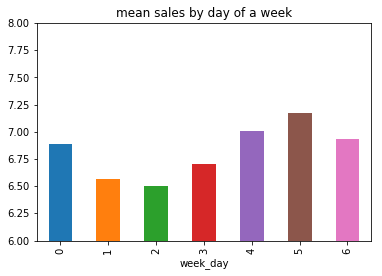

In [10]:
df.groupby('week_day')['Sales_size'].mean().plot(kind = 'bar', ylim = (6,8), title = 'mean sales by day of a week')

**Выводы:**
    
    Сезонность в значительной мере влияет на продажи. Это выражается:
     - Высокими средними продажами с мая по сентябрь
     - Высокими средними продажами в предпраздничные периоды
     - Низкими средними продажами в марте, апреле, ноябре, декабре

## Как признаки влияют на продажи. Можно ли с помощью признаков и сезонности предсказать продажи на неделю?

Для первоначального анализа как признаки влияют на продажи составим матрицу корреляции. Обратим внимание:
 - Исходные признаки не обладают высокой корреляцией с продажами
 - Наибольшей корреляцией обладают: **feature_1** - 14%, **feature_2** - 11%, **feature_5** - 11%
 - При этом **feature_1** и **feature_2** обладают высокой парной корреляцией - 96% (возможно эти признаки друг друга копируют)
 - Наименьшей корреляцией с продажами обладает **feature_7** < 1%

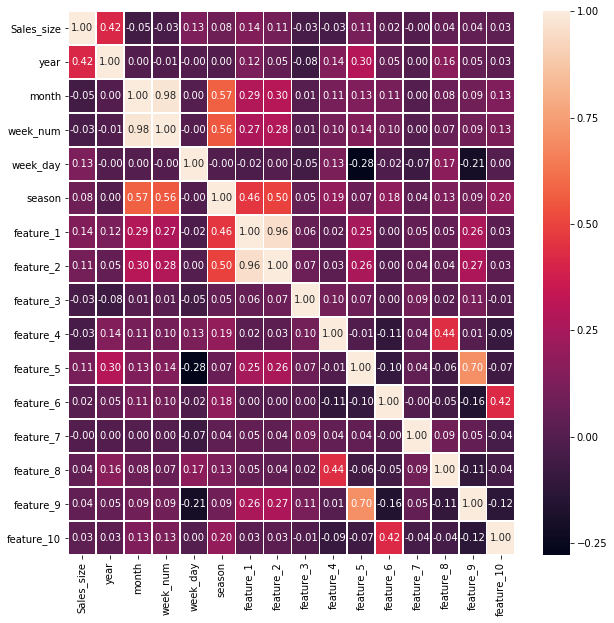

In [11]:
#выбрана корреляция Спирмена, т.к. она устойчива к выбросам
corr = df.corr(method = 'spearman')

plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True, fmt = '.2f', linewidths = 0.5)

Для анализа можно ли с помощью сезонности и признаков предсказать продажи на неделю будем строить модели и оценивать результаты их работы. Начнем с линейных моделей


### Forecasting

In [12]:
"""
определим функцию для оценки результатов работы моделей
в качестве основной метрики выберем r2, т.к. она является относительной метрикой и в идеале стремится к 1
в качестве вспомогательных метрик выберем rmse и mae
также для оценки прогноза будем смотреть на график, совмещенный с реальными продажами
"""

def print_results(title, y_true, y_pred):
    """
    вывод на экран основных метрик по результатам оценки прогноза
    """
    
    global r2, rmse, mae
    print('\n\033[1m' + title + '\033[0m')
    
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    mae = mean_absolute_error(y_true, y_pred)
    
    print('r2 - {:.2f}'.format(r2))
    print('rmse - {:.2f}'.format(rmse))
    print('mae - {:.2f}'.format(mae))
     
        
def namestr(obj, namespace):
    '''
    подготовка имени переменной для печати
    '''
    return [name for name in namespace if namespace[name] is obj]        


def plot_results(*predictions):
    """
    совмещение прогнозов моделей и реальных продаж на графике
    """
    
    plt.figure(figsize=(18,7))

    for prediction in predictions:
        name = namestr(prediction, globals())
        plt.plot(prediction, label = name[0])
        
    plt.plot(df.Sales_size, label = 'real sales')
    plt.legend()
    plt.show
    

### Linear models

 - Для начала возьмем 2 регрессии (Ridge, Lasso) и попробуем получить точные предсказания тренировочной выборки при обучении на самой себе 
 - После ручной настройки параметров регуляризации видим, что показатель r_2 очень низкий - 23%
 - График это подтверждает. Модели недообучены



Ridge regression
r2 - 0.23
rmse - 1.01
mae - 0.74

Lasso regression
r2 - 0.23
rmse - 1.01
mae - 0.74


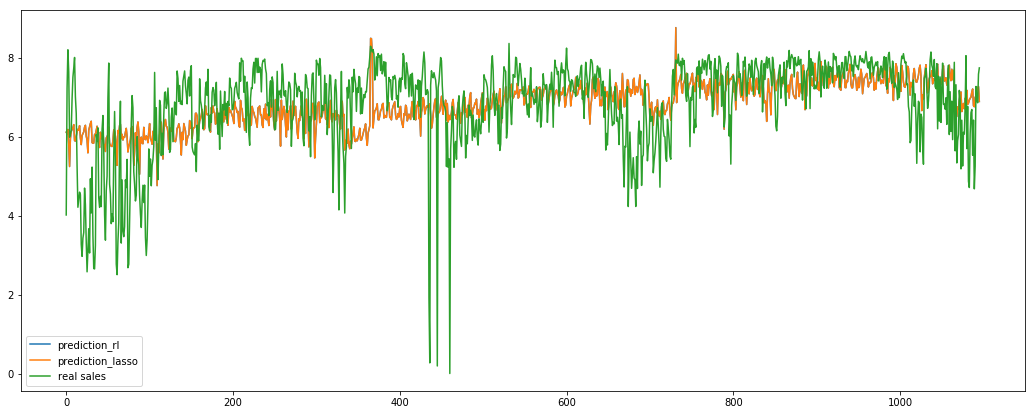

In [13]:
#regression models

new_date_features = ['year', 'month', 'week_num', 'week_day', 'season']
df_prepared = df[new_date_features + features_initial]

rl = Ridge(alpha=0.01)
lasso = Lasso(alpha=0.0001)

rl.fit(df_prepared, df.Sales_size)
prediction_rl = rl.predict(df_prepared)
print_results('Ridge regression', df.Sales_size, prediction_rl)

lasso.fit(df_prepared, df.Sales_size)
prediction_lasso = lasso.predict(df_prepared)
print_results('Lasso regression', df.Sales_size, prediction_lasso)

plot_results(prediction_rl, prediction_lasso)

Значения признаков имеют различные порядки, попробуем их масштабировать

In [14]:
#let's try to scale features

df_scaled = df_prepared.copy()
for feature in df_scaled.columns:
    df_scaled[feature] = (df_scaled[feature] - df_scaled[feature].mean()) / df_scaled[feature].std()
    

For scaled dataset:

Ridge regression
r2 - 0.23
rmse - 1.01
mae - 0.74

Lasso regression
r2 - 0.23
rmse - 1.01
mae - 0.74


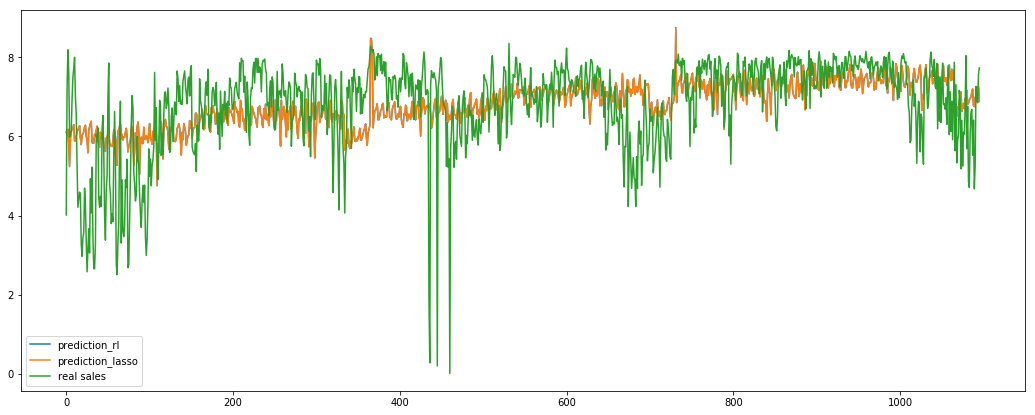

In [15]:
print('For scaled dataset:')

rl = Ridge(alpha=0.01)
lasso = Lasso(alpha=0.0001)

rl.fit(df_scaled, df.Sales_size)
prediction_rl = rl.predict(df_scaled)
print_results('Ridge regression', df.Sales_size, prediction_rl)

lasso.fit(df_scaled, df.Sales_size)
prediction_lasso = lasso.predict(df_scaled)
print_results('Lasso regression', df.Sales_size, prediction_lasso)

plot_results(prediction_rl, prediction_lasso)


Ничего не изменилось. Попробуем добавить признаки даты в бинарном формате (one-hot encoding)

In [16]:
features_one_hot = []

for each in new_date_features:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    features_one_hot += list(dummies.columns)
    df = pd.concat([df, dummies], axis=1)
    
df_prepared = df[features_one_hot + features_initial]



Ridge regression
r2 - 0.52
rmse - 0.80
mae - 0.57

Lasso regression
r2 - 0.52
rmse - 0.80
mae - 0.57


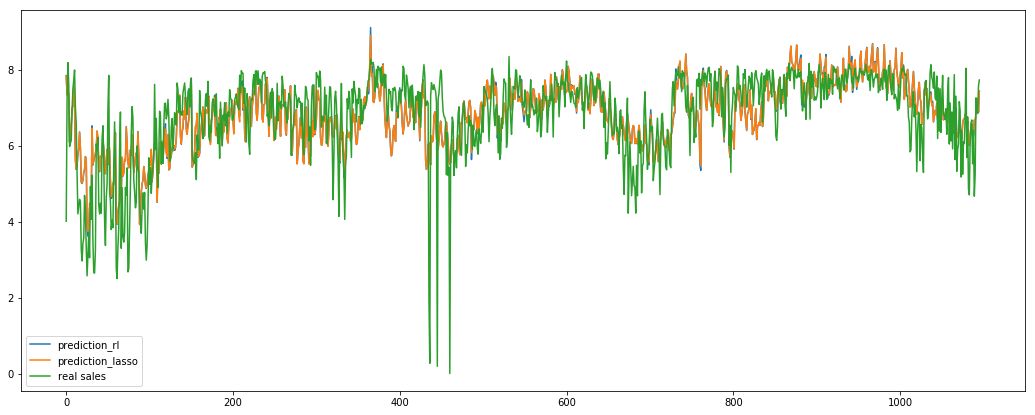

In [17]:
rl = Ridge(alpha=0.0001)
lasso = Lasso(alpha=0.0001)

rl.fit(df_prepared, df.Sales_size)
prediction_rl = rl.predict(df_prepared)
print_results('Ridge regression', df.Sales_size, prediction_rl)

lasso.fit(df_prepared, df.Sales_size)
prediction_lasso = lasso.predict(df_prepared)
print_results('Lasso regression', df.Sales_size, prediction_lasso)

plot_results(prediction_rl, prediction_lasso)


Получаем r2 = 0.52 после ручной настройки коэффициентов регуляризации. Показатель r_2 по прежнему остается низким, учитывая что мы предсказываем тренировочную выборку при обучении на ней же.

Посмотрим какие признаки являются основными при построении регрессии Лассо. Видим:
 - Наиболее значимыми для построения регрессии являются признаки сезонности
 - Числовые признаки оказывают очень незначительное влияние на продажи. Наибольшее значение среди них имеет feature_2 - 0.03

In [18]:
pd.set_option('display.max_rows', 35, 'display.float_format', '{:,.2f}'.format)

feature_importance = pd.DataFrame({"feature":df_prepared.columns,
              'coef': lasso.coef_
             })
feature_importance['coef'] = abs(feature_importance['coef'])

feature_importance.sort_values('coef', ascending= False)

,coef,feature
24,4.25,week_num_10
28,3.73,week_num_14
29,3.52,week_num_15
26,3.25,week_num_12
27,3.14,week_num_13
25,3.02,week_num_11
23,2.69,week_num_9
30,2.60,week_num_16
31,2.51,week_num_17
76,2.26,season_2


**Итого: ** имея большую ошибку на тренировочной выборке, можно сделать вывод, что линейные модели недообучены. Попробуем использовать более мощные модели, чтобы более точно предсказывать тренировочную выборку

### XGBoost

Возьмем модель XGBoost. Для начала попробуем обучить модель при валидации на данных 2017 года

In [19]:
#XGBoost

df_prepared = df[new_date_features + features_initial]

#граница между 2016 и 2017 годами
border = 731

train_X = df_prepared.iloc[:border]
train_y = df.Sales_size.iloc[:border]
val_X = df_prepared.iloc[border:]
val_y = df.Sales_size.iloc[border:]

model = XGBRegressor(
    max_depth=6,
    n_estimators=1000,
    min_child_weight=30, 
    colsample_bytree=0.95, 
    subsample=1, 
    eta=0.3,    
    seed=42)

model.fit(
    train_X, 
    train_y, 
    eval_metric="rmse", 
    eval_set=[(train_X, train_y), (val_X, val_y)], 
    verbose=50,
    early_stopping_rounds = 10)

prediction_xgboost = model.predict(df_prepared)

[0]	validation_0-rmse:5.57817	validation_1-rmse:6.27521
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[50]	validation_0-rmse:0.661162	validation_1-rmse:0.953669
[100]	validation_0-rmse:0.590855	validation_1-rmse:0.929022
Stopping. Best iteration:
[95]	validation_0-rmse:0.598273	validation_1-rmse:0.926178



Таким образом мы видим, что модель хорошо обучается на тренировочной выборке (при снижении min child weight легко достигаются показатели r2 = 0.98 - т.е. модель достаточно мощная), при этом точность предсказания валидационной выборки очень низкая, r2 < 0 (даже после ручной настройки гиперпараметров модели)


2015 - 2017
r2 - 0.60
rmse - 0.72
mae - 0.53

2015 - 2016 (train)
r2 - 0.76
rmse - 0.60
mae - 0.40

2017 (valid)
r2 - -0.81
rmse - 0.93
mae - 0.78


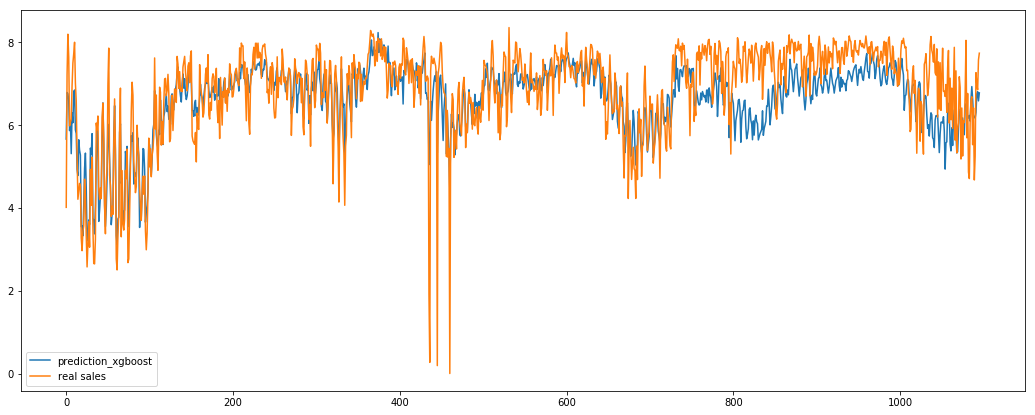

In [20]:
print_results('2015 - 2017', df.Sales_size, prediction_xgboost)

print_results('2015 - 2016 (train)', df.Sales_size[0:border], prediction_xgboost[0:border])

print_results('2017 (valid)', df.Sales_size[border:], prediction_xgboost[border:])

plot_results(prediction_xgboost)


По условию задачи нам необходимо было определить возможно ли предсказывать продажи на неделю вперед. 
Попробуем предсказывать продажи для каждой недели 2017 года на исторических данных. В качестве основной метрики оставим r2

In [21]:
#predict sales a week ahead

border = 732
r2_avg = 0

week_data = pd.DataFrame({'week_num':[],
                         'r2': []})
week_data = week_data[['week_num', 'r2']]

for week_border in range(border, len(df),7):
    
    #time series split
    train_X = df_prepared.iloc[:week_border]
    train_y = df.Sales_size.iloc[:week_border]
    val_X = df_prepared.iloc[week_border : week_border + 7]
    val_y = df.Sales_size.iloc[week_border : week_border + 7]

    model = XGBRegressor(
        max_depth=6,
        n_estimators=1000,
        min_child_weight=20, 
        colsample_bytree=0.95, 
        subsample=1, 
        eta=0.3,    
        seed=42)

    model.fit(
        train_X, 
        train_y, 
        eval_metric="rmse", 
        eval_set=[(train_X, train_y), (val_X, val_y)], 
        verbose=False,
        early_stopping_rounds = 10)
    
    prediction_xgboost = model.predict(val_X)
    
    #store the history
    week_data.loc[val_X.week_num.iloc[0], 'week_num'] = val_X.week_num.iloc[0]
    week_data.loc[val_X.week_num.iloc[0], 'r2'] = r2_score(val_y, prediction_xgboost)    

print('\nr2_avg = {:.2f}'.format(week_data.r2.mean()))



r2_avg = -1.41


Точность предсказания на неделю вперед является очень низкой, с показателем r2 не выше 0.43 для любой недели

In [22]:
pd.set_option('display.max_rows', 10)

week_data.week_num = week_data.week_num.astype('int')
week_data.sort_values('r2', ascending = False)

,week_num,r2
10,10,0.43
47,47,0.41
46,46,0.38
2,2,0.37
9,9,0.33
...,...,...
5,5,-5.38
20,20,-6.57
16,16,-8.99
1,1,-9.44


**Выводы:**
    
 - числовые признаки влияют на продажи очень незначительно, основное влияние оказывают сезонные признаки
 - с помощью числовых признаков и признаков сезонности на текущий момент нельзя предсказать продажи на неделю вперед с удовлетворительной точностью
 
**Дальнейшие шаги**:
 - сбор дополнительных числовых признаков для построения прогноза
 - сбор дополнительной истории продаж для построения прогноза
 - оценка возможности применения подходов Deep Learning (LSTM, итд)
 - оценка возможности предсказания продаж с помощью моделей временных рядов (без использования числовых признаков)
 